# Optimization of an S-bend with CMA-ES

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

[Covariance Matrix Adaptation Evolution Strategy (CMA-ES)](https://en.wikipedia.org/wiki/CMA-ES) is a robust evolutionary algorithm used for solving optimization problems in continuous domains. It stands out for its ability to adaptively adjust the covariance matrix, which guides the generation of new solution candidates, enabling it to efficiently navigate complex, multimodal landscapes. Its self-adaptive mechanism and population-based approach make it a powerful tool for a wide range of applications.

The steps in a CMA-ES are typically as follows:

1. **Initialization**: Generate an initial population of candidate solutions randomly within the search space.

2. **Initialize the parameters**: mean of the search distribution, covariance matrix, step size, etc.

3. **Evaluation**: Assess each candidate in the current population using the objective function to determine its fitness.

4. **Selection**: Select a subset of the best-performing candidates based on their fitness scores.

5. **Update Mean**: Calculate the new mean of the selected candidates, which will be used to sample the next generation.

6. **Adapt Covariance Matrix**: Update the covariance matrix based on the distribution of the selected candidates. This step is crucial as it adapts the sampling strategy to the shape of the objective function's landscape.

7. **Adapt Step Size**: Adjust the step size, which controls the global scale of the search. This is typically done using a mechanism like path length control, which helps in maintaining an appropriate exploration-exploitation balance.

8. **Generate New Population**: Sample a new population of candidates based on the updated mean, covariance matrix, and step size.

9. **Termination Check**: Check for termination criteria (e.g., maximum number of iterations, satisfactory solution quality, or stagnation in improvement).

10. **Repeat**: If termination criteria are not met, return to step 2 with the new population and continue the process.

11. **Output**: Once termination criteria are met, output the best solution found or the final population depending on the specific requirements of the problem.

CMA-ES can be effectively applied to the design optimization of photonic components.
`Yuto Miyatake, Kasidit Toprasertpong, Shinichi Takagi, and Mitsuru Takenaka, "Design of compact and low-loss S-bends by CMA-ES," Opt. Express 31, 43850-43863 (2023)` [DOI:10.1364/OE.504866](https://doi.org/10.1364/OE.504866) demonstrates the optimization of a compact, low-loss waveguide S-bend using CMA-ES. In this notebook, we follow this work and optimize a silicon waveguide S-bend. We use the CMA-ES optimizer from the open-source package [pycma](https://github.com/CMA-ES/pycma) so we can set up the optimization very quickly.

<img src="img/optimized_sbend.png" width="450" alt="Schematic of the S-bend">

`Tidy3D` is a powerful tool for photonic design optimization due to its fast speed and high throughput. Besides CMA-ES, we have demonstrated particle swarm optimizations of a [polarization beam splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/) and a [bullseye cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/), genetic algorithm optimization of an [on-chip reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/), and direct binary search optimization of an [optical switch](https://www.flexcompute.com/tidy3d/examples/notebooks/OpticalSwitchDBS/). Furthermore, we also have a growing list of gradient-based adjoint optimization examples including

1. [Mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/),

2. [Waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/),

3. [Metalens](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/),

4. [Waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/), 

5. [Multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin9WDM/),

6. [Y-branch](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin10YBranchLevelSet/),

7. [MZI circuit](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin11CircuitMZI/),

8. [Light extractor](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin12LightExtractor/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cma

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

The simulation wavelength range is 1500 nm to 1600 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency

n_freqs = 11
ldas = np.linspace(1.5, 1.6, n_freqs)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

For simplicity, we will use the silicon and oxide media directly from the [material library](../api/material_library.html#).

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]

sio2 = td.material_library["SiO2"]["Palik_Lossless"]

The input and output straight waveguides have a 430 nm width and 220 nm thickness. The S-bend has a size of 3.5 µm and its boundaries are characterized by a Bezier curve with 7 control points. Therefore, the 14 parameters corresponding to the $xy$ coordinates of the control points tune the shape and width of the bend. The first and last points are fixed to ensure a smooth connection to the straight waveguides. The y coordinate of the middle control point is also fixed. Therefore, we have a total of 9 tunable parameters that can be optimized.

In [4]:
s = 3.5  # s-bend size
w = 0.43  # straight waveguide width
t = 0.22  # waveguide thickness
buffer = 1.5  # buffer spacing
inf_eff = 1e2  # effective infinity

# initial values of the tunable parameters corresponding to the coordinates of the control points
x1 = 0.7675
x2 = 0.215
x3 = 0.215
x4 = 0.215
x5 = -0.9825
y1 = 1.535
y2 = 0.7675
y4 = -0.9825
y5 = -1.965

# initial parameter vector
x0 = [x1, x2, x3, x4, x5, y1, y2, y4, y5]

We define a function `bezier_curve` that takes the coordinates of the control points and returns the Bezier curve. To test it, we generate the Bezier curve that describes the bottom curve of the S-bend with the initial control points defined earlier and plot them.

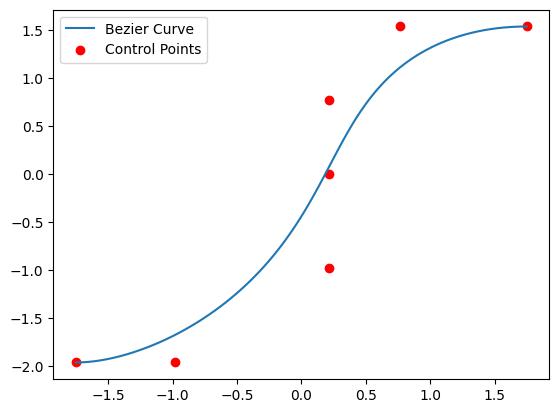

In [5]:
def bezier_curve(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    n = len(control_points) - 1  # degree of the Bézier curve

    for i in range(n + 1):
        binomial_coeff = math.factorial(n) / (math.factorial(i) * math.factorial(n - i))
        term = binomial_coeff * (1 - t) ** (n - i) * t**i
        curve += np.outer(term, control_points[i])

    return curve


# define 7 control points
control_points = np.array(
    [
        [-s / 2, -s / 2 - w / 2],
        [x5, y5],
        [x4, y4],
        [x3, 0],
        [x2, y2],
        [x1, y1],
        [s / 2, s / 2 - w / 2],
    ]
)

# generate Bézier curve
curve_bottom = bezier_curve(control_points)

plt.plot(curve_bottom[:, 0], curve_bottom[:, 1], label="Bezier Curve")
plt.scatter(control_points[:, 0], control_points[:, 1], color="red", label="Control Points")
plt.legend()
plt.show()

The top curve of the S-bend is simply a 180 degree rotation of the bottom curve. With both curves, the bend can be simply defined as a [PolySlab](../api/_autosummary/tidy3d.PolySlab.html). The input and output straight waveguides can be defined using Box.

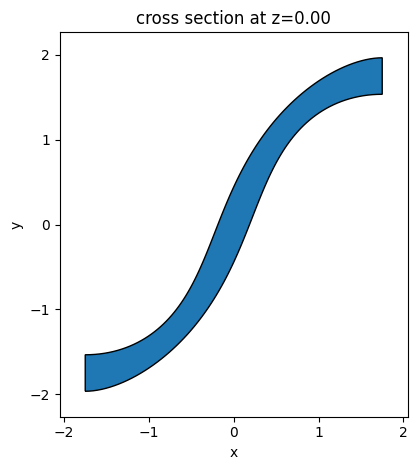

In [6]:
vertices = np.vstack((curve_bottom, -curve_bottom))

sbend = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-t / 2, t / 2)), medium=si
)

waveguide_in = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -s / 2 - w / 2, -t / 2), rmax=(-s / 2, -s / 2 + w / 2, t / 2)
    ),
    medium=si,
)

waveguide_out = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(s / 2, s / 2 - w / 2, -t / 2), rmax=(inf_eff, s / 2 + w / 2, t / 2)
    ),
    medium=si,
)

sbend.plot(z=0)
plt.show()

We will add a [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) to launch the TE0 mode at the input waveguide and add a [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) at the output waveguide to measure transmission efficiency.

In [7]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(-s / 2 - buffer / 2, -s / 2, 0),
    size=(0, 4 * w, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(s / 2 + buffer / 2, s / 2, 0),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

To facilitate the optimization, we define a function `make_sim` that takes the design parameter vector and returns a [Simulation](../api/_autosummary/tidy3d.Simulation.html).

In [8]:
def make_sim(x):
    control_points = np.array(
        [
            [-s / 2, -s / 2 - w / 2],
            [x[4], x[8]],
            [x[3], x[7]],
            [x[2], 0],
            [x[1], x[6]],
            [x[0], x[5]],
            [s / 2, s / 2 - w / 2],
        ]
    )

    curve_bottom = bezier_curve(control_points)

    vertices = np.vstack((curve_bottom, -curve_bottom))

    sbend = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-t / 2, t / 2)), medium=si
    )

    run_time = 5e-13  # simulation run time

    return td.Simulation(
        size=(s + 2 * buffer, s + 2 * buffer, 10 * t),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[waveguide_in, waveguide_out, sbend],
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
        symmetry=(0, 0, 1),
    )

## Optimization Setup

The objective of the optimization is to reduce the loss at the S-bend. Therefore, the objective function is simply the transmission to the output waveguide. By default, the objective evaluation is sequential, i.e. in each generation the objective function is calculated for each population one at a time. To leverage the parallel run of Tidy3D, we want to evaluate the objective functions for all populations in the generation at once. To achieve this, we need to do some customization for the optimizer, which we will demonstrate later. For now, let's assume that the objective function takes a 2D array of parameter vectors instead of a single parameter vector and returns a 1D array of objective function values. Each row of the 2D array corresponds to one parameter vector in the generation and the number of rows equals the number of populations. 

In [9]:
def compute_transmission(sim_data):
    amps = sim_data["mode"].amps.sel(mode_index=0, direction="+").values
    return np.abs(amps) ** 2


def objective_function(xs):
    sims = {}
    for i, x in enumerate(xs):
        sim = make_sim(x)
        sims[f"population_{i}"] = sim

    batch = web.Batch(simulations=sims, verbose=False)
    batch_results = batch.run(path_dir="data")

    T = []
    for i, _ in enumerate(xs):
        sim_data = batch_results[f"population_{i}"]
        T.append(-10 * np.log10(np.mean(compute_transmission(sim_data))))
    return T

Define the hyperparameters for the optimization. We use a population size of 10 and run the optimization for a total of 12 generations. The initial standard deviation is set to 0.05, which is empirically determined. This parameter determines the size of the explored parameter space initially. Too large of an initial standard deviation could lead to a self-intersecting [PolySlab](../api/_autosummary/tidy3d.PolySlab.html). For reproducibility, we also use a fixed random seed.

With the hyperparameters, we define the CMA-ES optimizer.

In [10]:
dim = len(x0)
population_size = 10
max_generations = 12
sigma0 = 0.05
random_seed = 12345

es = cma.CMAEvolutionStrategy(
    x0, sigma0, {"popsize": population_size, "maxiter": max_generations, "seed": random_seed}
)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=12345, Mon Feb 19 22:55:19 2024)


## Run Optimization

With the objective function and optimizer set up, we can start the optimization. As we mentioned previously, we need to customize the optimization loop slightly such that the objective functions for the entire population can be evaluated in parallel. 

We also keep track of the best objective function value and display it at the end of each generation. We can see that the transmission improved from 0.271 dB in the first generation to 0.045 dB in the last generation, which is a significant improvement. 

In [11]:
best_values = []

generation = 0
while not es.stop():
    solutions = es.ask()
    function_values = objective_function(solutions)
    es.tell(solutions, function_values)

    best_values.append(es.result[1])

    # Print message for each generation
    print(f"Generation {generation}: Best function value = {es.result[1]:.3f}")

    generation += 1

22:55:51 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:55:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:55:53 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:55:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:55:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 0: Best function value = 0.271


22:56:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:23 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:25 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 1: Best function value = 0.265


22:56:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:53 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:56:56 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 2: Best function value = 0.229


22:57:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:23 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:25 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 3: Best function value = 0.216


22:57:51 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:53 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:57:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 4: Best function value = 0.173


22:58:21 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:23 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:25 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 5: Best function value = 0.119


22:58:52 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:53 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:54 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:58:56 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 6: Best function value = 0.082


22:59:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:25 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:26 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:28 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 7: Best function value = 0.064


22:59:55 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:56 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:57 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:58 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

22:59:59 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 8: Best function value = 0.064


23:00:27 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:28 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:29 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:30 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:00:32 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 9: Best function value = 0.061


23:01:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:01 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:02 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:03 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:04 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 10: Best function value = 0.043


23:01:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:32 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:34 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:01:35 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Generation 11: Best function value = 0.040


Plot the best objective value as a function of generation. 

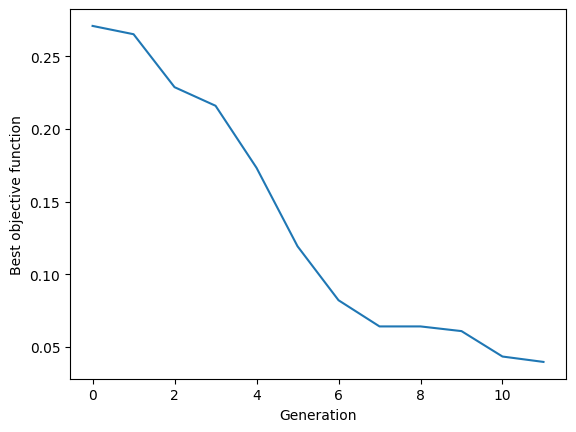

In [12]:
plt.plot(best_values)
plt.xlabel("Generation")
plt.ylabel("Best objective function")
plt.show()

## Final Design

After the optimization, we can inspect the optimized design more closely. First, extract the optimal parameter vector from the optimizer. Then define a [Simulation](../api/_autosummary/tidy3d.Simulation.html) and visualize it. 

In [13]:
x_opt = es.result[0]
sim_opt = make_sim(x_opt)
sim_opt.plot_3d()

To help visualize the field propagation, we add a [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) to the simulation and run it again.

In [14]:
# add a field monitor to visualize field distribution at z=0
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

sim_opt = sim_opt.copy(update={"monitors": [mode_monitor, field_monitor]})
sim_data_opt = web.run(simulation=sim_opt, task_name="final_design")

             Created task 'final_design' with task_id                           
             'fdve-734da986-9482-49df-a63f-2c8b84ecc51b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=474748;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=11930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\taskId]8;;\]8;id=474748;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\=]8;;\]8;id=50780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\fdve]8;;\]8;id=474748;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\-734da986-948]8;;\
             ]8;id=474748;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\2-49df-a63f-2c8b84ecc51b']8;;\.

Output()

23:01:36 PST status = queued

Output()

23:01:40 PST status = preprocess

23:01:42 PST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

23:01:51 PST early shutoff detected at 64%, exiting.

             status = postprocess

Output()

23:01:54 PST status = success

             View simulation result at                                          
             ]8;id=480883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=608329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\taskId]8;;\]8;id=480883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\=]8;;\]8;id=38971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\fdve]8;;\]8;id=480883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\-734da986-948]8;;\
             ]8;id=480883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-734da986-9482-49df-a63f-2c8b84ecc51b\2-49df-a63f-2c8b84ecc51b']8;;\.

Output()

23:01:55 PST loading simulation from simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

After the simulation is complete, plot the transmission spectrum, which shows a very low loss.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

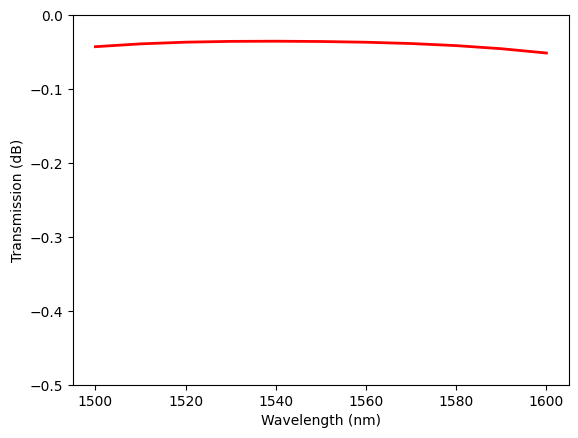

In [15]:
T_opt = 10 * np.log10(compute_transmission(sim_data_opt))
plt.plot(ldas * 1e3, T_opt, "red", linewidth=2)
plt.ylim(-0.5, 0)
plt.ylabel("Transmission (dB)")
plt.xlabel("Wavelength (nm)")
plt.show()

Lastly, plot the field intensity distribution to visualize the energy flow. The optimized design allows a smooth mode transition at the two bends such that the loss is minimal. 

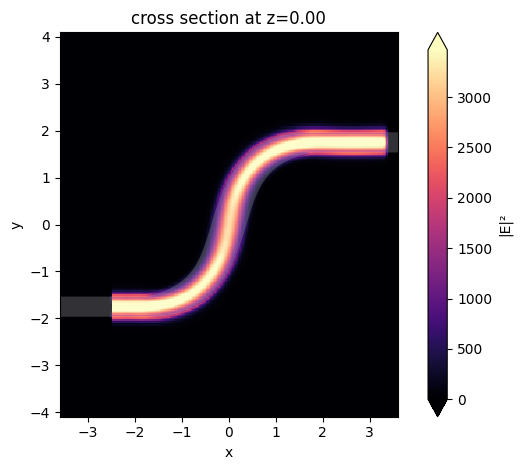

In [16]:
sim_data_opt.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()

With the optimized design, we can directly export a GDS file of the S-bend for fabrication. 

In [17]:
sim_opt.to_gds_file(fname="misc/optimized_sbend.gds", z=0)